<a href="https://colab.research.google.com/github/PranavDixit2/LungCancer/blob/main/XRay_V15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python tensorflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import kagglehub
path = kagglehub.dataset_download("quynhlecl/lung-cancer-x-ray")
print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.2 MB/s eta 0:00:00


100%|██████████| 2.28G/2.28G [00:16<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1


In [4]:
# 1. Data Paths & Exploration


# Update these paths based on your dataset structure.
root_dataset_path = "/root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1/chest_xray_lung/"
train_dataset_path = os.path.join(root_dataset_path, "train")
val_dataset_path   = os.path.join(root_dataset_path, "val")
test_dataset_path  = os.path.join(root_dataset_path, "test")



In [5]:
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    return class_counts

class_counts = explore_dataset(train_dataset_path)



Dataset Overview:
Total Classes: 2
Total Images: 5216
Class Distribution:
  NORMAL: 1341
  Cancer: 3875


In [9]:
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(generator):
    labels = generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return {i: weight for i, weight in enumerate(class_weights)}


In [7]:
# 2. Data Generators

# Adjust augmentation: for chest X-rays, avoid transformations that could misrepresent anatomy.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    # horizontal_flip is omitted to preserve anatomical left/right details.
)



In [10]:
# For validation and test, only apply preprocessing.
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# For binary classification, use 'binary' class mode.
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Compute class weights
class_weights = get_class_weights(train_generator)
# ------------------------------


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# 3. Model Definition & Fine-Tuning
# ------------------------------

def create_model(fine_tune=False, fine_tune_at=140):
    """
    Create a model using ResNet50 as the base.
    If fine_tune is True, unfreeze layers from fine_tune_at onward.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the entire base model initially
    base_model.trainable = False

    # Build our custom classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Optionally unfreeze the top layers of the base model for fine-tuning
    if fine_tune:
        base_model.trainable = True
        # Freeze all layers before the fine_tune_at layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Recompile with a lower learning rate for fine-tuning
        model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

# Instantiate model (set fine_tune=True when ready to fine-tune)
model = create_model(fine_tune=False)
model.summary()

# ------------------------------


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# 4. Training with Cross-Validation
# ------------------------------

# Helper function to extract data and labels from a generator (for cross-validation)
def extract_data_and_labels(generator):
    data = []
    labels = []
    for _ in range(len(generator)):
        images, batch_labels = next(generator)
        data.append(images)
        labels.append(batch_labels)
    return np.vstack(data), np.concatenate(labels)

train_data, train_labels = extract_data_and_labels(train_generator)



In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet_updated.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Using 5-fold cross-validation for robustness
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in kf.split(train_data, train_labels):
    print(f"\n--- Training Fold {fold_no} ---")
    # Create data generators for current fold
    fold_train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[train_idx], train_labels[train_idx], batch_size=32
    )
    fold_val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[val_idx], train_labels[val_idx], batch_size=32
    )

    # Create a new instance of the model for each fold.
    model = create_model(fine_tune=False)
    history = model.fit(
        fold_train_gen,
        epochs=3,
        validation_data=fold_val_gen,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    val_loss, val_acc = model.evaluate(fold_val_gen)
    print(f"Fold {fold_no} - Validation Accuracy: {val_acc:.2f}")
    fold_no += 1



--- Training Fold 1 ---
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8215 - loss: 0.4590

82/82 ━━━━━━━━━━━━━━━━━━━━ 867s 11s/step - accuracy: 0.8223 - loss: 0.4568 - val_accuracy: 0.9479 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 2/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9471 - loss: 0.1428

82/82 ━━━━━━━━━━━━━━━━━━━━ 848s 10s/step - accuracy: 0.9471 - loss: 0.1427 - val_accuracy: 0.9490 - val_loss: 0.1332 - learning_rate: 0.0010
Epoch 3/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9618 - loss: 0.0916

82/82 ━━━━━━━━━━━━━━━━━━━━ 845s 10s/step - accuracy: 0.9617 - loss: 0.0917 - val_accuracy: 0.9590 - val_loss: 0.1069 - learning_rate: 0.0010
82/82 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.9581 - loss: 0.0998
Fold 1 - Validation Accuracy: 0.96

--- Training Fold 2 ---
Epoch 1/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 855s 10s/step - accuracy: 0.8093 - loss: 0.4804 - val_accuracy: 0.9429 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 2/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9339 - loss: 0.1700

82/82 ━━━━━━━━━━━━━━━━━━━━ 846s 10s/step - accuracy: 0.9340 - loss: 0.1699 - val_accuracy: 0.9643 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 3/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9559 - loss: 0.1254

82/82 ━━━━━━━━━━━━━━━━━━━━ 844s 10s/step - accuracy: 0.9558 - loss: 0.1254 - val_accuracy: 0.9697 - val_loss: 0.0858 - learning_rate: 0.0010
82/82 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.9727 - loss: 0.0825
Fold 2 - Validation Accuracy: 0.97


20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.9298 - loss: 0.1662
Test Accuracy: 0.90
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step
              precision    recall  f1-score   support

      Cancer       0.89      0.95      0.92       390
      NORMAL       0.90      0.81      0.85       234

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.89       624

AUC-ROC: 0.96


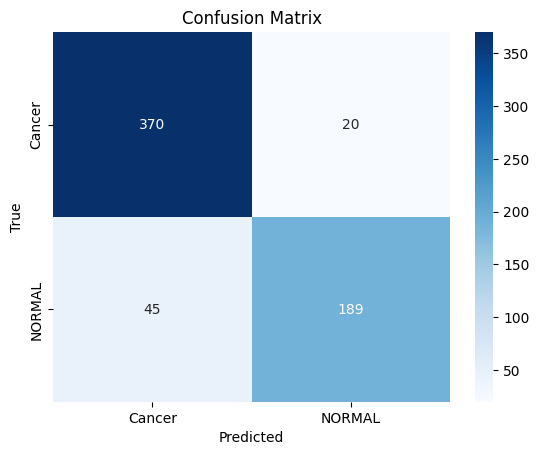

In [15]:
# 5. Final Evaluation on Test Set

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ------------------------------


In [18]:
for layer in model.layers:
    print(layer.name)

input_layer_5
resnet50
global_average_pooling2d_2
dense_4
dropout_2
dense_5
